In [91]:
import math
from itertools import combinations
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from ortools.linear_solver import pywraplp

plt.style.use(['dark_background'])


In [79]:
# define shortcuts for each slot and full-text labels
slot_times = [
    [1, 's1', 'MWF 9:00-10:15', 'M/W/F', '9:00', '10:15'],
    [2, 's2', 'TT 9:00-10:15', 'T/TH', '9:00', '10:15'],
    [3, 's3', 'MWF 10:30-11:45', 'M/W/F', '10:30', '11:45'],
    [4, 's4', 'TT 10:30-11:45', 'T/TH', '10:30', '11:45'],
    [5, 's5', 'MWF 12:00-1:15', 'M/W/F', '12:00', '1:15'],
    [6, 's6', 'TT 12:00-1:15', 'T/TH', '12:00', '1:15'],
    [7, 's7', 'MWF 1:30-2:45', 'M/W/F', '1:30', '2:45'],
    [8, 's8', 'TT 1:30-2:45', 'T/TH', '1:30', '2:45'],
    [9, 's9', 'MWF 3:00-4:15', 'M/W/F', '3:00', '4:15'],
    [10, 's10', 'TT 3:00-4:15', 'T/TH', '3:00', '4:15'],
]

# create a list with all the slots
slots = [i[1] for i in slot_times]

# and define two groups of slots, those for MW(F) and those for T-Th:
mwf_set = [i[1] for i in slot_times if i[3] == 'M/W/F']
tt_set = [i[1] for i in slot_times if i[3] == 'T/TH']

# define the day sets - zero-indexed
mwf_slots = [i[0] - 1 for i in slot_times if i[3] == 'M/W/F']
tt_slots = [i[0] - 1 for i in slot_times if i[3] == 'T/TH']
fas_slot = [9]  # Tuesdays 3-5pm is the FAS meeting slot

# define the start time sets
t900_set = [i[1] for i in slot_times if i[4] == '9:00']
t1030_set = [i[1] for i in slot_times if i[4] == '10:30']
t1200_set = [i[1] for i in slot_times if i[4] == '12:00']
t130_set = [i[1] for i in slot_times if i[4] == '1:30']
t300_set = [i[1] for i in slot_times if i[4] == '3:00']

# define the start time slots - zero-indexed
t900 = [i[0] - 1 for i in slot_times if i[4] == '9:00']
t1030 = [i[0] - 1 for i in slot_times if i[4] == '10:30']
t1200 = [i[0] - 1 for i in slot_times if i[4] == '12:00']
t130 = [i[0] - 1 for i in slot_times if i[4] == '1:30']
t300 = [i[0] - 1 for i in slot_times if i[4] == '3:00']

print(f'MWF slots (0-based): {mwf_slots}')
print(f'TT slots (0-based): {tt_slots}')
print(f'FAS slot (0-based): {fas_slot}')


MWF slots (0-based): [0, 2, 4, 6, 8]
TT slots (0-based): [1, 3, 5, 7, 9]
FAS slot (0-based): [9]


In [ ]:
# function definitions
def get_stats(matrix, no_slots, no_courses):
    """Return basic statistics for a matrix of courses and time slots."""
    # count courses in each slot set
    tt_slots = [1, 3, 5, 7, 9]
    mwf_slots = [0, 2, 4, 6, 8]
    slot_sum = matrix.sum(axis=0)
    mwf_count = 0
    tt_count = 0

    for s in mwf_slots:
        mwf_count += slot_sum[s]

    for s in tt_slots:
        tt_count += slot_sum[s]

    pattern_variance = abs(mwf_count - tt_count)

    # then determine the slots with maximum and minimum number of courses
    mx = max(slot_sum)
    mn = min(slot_sum)
    max_slot = [i for i, j in enumerate(slot_sum) if j == mx]
    min_slot = [i for i, j in enumerate(slot_sum) if j == mn]
    slot_variance = mx - mn

    print(f'Number of slots: {no_slots}')
    print(f'Number of courses: {no_courses}')
    print(f'Number of courses in MWF slots: {mwf_count}')
    print(f'Number of courses in TT slots: {tt_count}')
    print(f'Day pattern variance: {pattern_variance}')
    print(f'Slot(s) with maximum no. of courses: {max_slot} {mx}')
    print(f'Slot(s) with minimum no. of courses: {min_slot} {mn}')
    print(f'Slot variance: {slot_variance} [should be <= 2] \n')
    print('Course distribution:')
    for n, _sum in enumerate(slot_sum):
        print(f'{slot_times[n][2]} -> {_sum} courses')
    print('\n')


def kendalltau_dist(rank_a, rank_b):
    """Calculate Kendall's Tau distance between two ranking columns."""
    tau = 0
    n_candidates = len(rank_a)
    for i, j in combinations(range(n_candidates), 2):
        tau += np.sign(rank_a[i] - rank_a[j]) == -np.sign(rank_b[i] - rank_b[j])
    return tau


def build_graph(ranks):
    """Build a directed graph from the ranks."""
    n_voters, n_candidates = ranks.shape
    edge_weights = np.zeros((n_candidates, n_candidates))
    for i, j in combinations(range(n_candidates), 2):
        preference = ranks[:, i] - ranks[:, j]
        h_ij = np.sum(preference < 0)  # prefers i to j
        h_ji = np.sum(preference > 0)  # prefers j to i
        if h_ij > h_ji:
            edge_weights[i, j] = h_ij - h_ji
        elif h_ij < h_ji:
            edge_weights[j, i] = h_ji - h_ij
    return edge_weights


def rankaggr_lp(ranks):  # noqa: C901, PLR0912
    """Aggregate rankings using linear programming to find Kemeny-Young consensus."""
    n_voters, n_candidates = ranks.shape

    # Check if we have valid data
    if n_voters == 0 or n_candidates == 0:
        return float('inf'), np.zeros(n_candidates)

    solver = pywraplp.Solver('KemenyYoung', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Variables: x[i,j] = 1 if candidate i is ranked before candidate j
    x = {}
    for i in range(n_candidates):
        for j in range(n_candidates):
            if i != j:
                x[i, j] = solver.BoolVar(f'x_{i}_{j}')

    # Objective: minimize total Kendall's Tau distance
    obj_terms = []
    for voter in range(n_voters):
        for i in range(n_candidates):
            for j in range(n_candidates):
                # Only add penalty if both preferences are non-zero
                if i != j and ranks[voter, i] > 0 and ranks[voter, j] > 0:
                    if ranks[voter, i] < ranks[voter, j]:  # voter prefers i over j
                        obj_terms.append(x[j, i])  # penalty if consensus disagrees
                    elif ranks[voter, i] > ranks[voter, j]:  # voter prefers j over i
                        obj_terms.append(x[i, j])  # penalty if consensus disagrees

    # If no objective terms, return equal ranking
    if not obj_terms:
        return 0, np.ones(n_candidates)

    solver.Minimize(solver.Sum(obj_terms))

    # Constraints: transitivity
    for i in range(n_candidates):
        for j in range(n_candidates):
            for k in range(n_candidates):
                if j not in (i, k) and i != k:
                    solver.Add(x[i, j] + x[j, k] + x[k, i] <= 2)  # noqa: PLR2004

    # Solve
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # Extract consensus ranking
        consensus_scores = np.zeros(n_candidates)
        for i in range(n_candidates):
            for j in range(n_candidates):
                if i != j and x[i, j].solution_value() > 0.5:  # noqa: PLR2004
                    consensus_scores[j] += 1  # j is ranked after i

        return solver.Objective().Value(), consensus_scores

    # Fallback to simple average ranking (excluding zeros)
    avg_ranks = np.zeros(n_candidates)
    for j in range(n_candidates):
        valid_prefs = ranks[:, j][ranks[:, j] > 0]
        if len(valid_prefs) > 0:
            avg_ranks[j] = np.mean(valid_prefs)
        else:
            avg_ranks[j] = 2.5  # neutral preference

    return float('inf'), avg_ranks


def get_slots_popularity(data):
    """Calculate slot popularity using Kemeny-Young consensus ranking."""
    # Convert preference data to rankings matrix
    ranks = data.values  # courses x slots matrix

    # Get Kemeny-Young consensus ranking
    score, consensus_ranks = rankaggr_lp(ranks.T)  # transpose to slots x courses

    # Convert consensus ranks to popularity scores
    # Lower rank = more popular = higher penalty
    max_rank = np.max(consensus_ranks)
    slots_pop = {}

    for i, slot in enumerate(data.columns):
        # Normalize so most popular slot gets highest penalty
        popularity = (max_rank - consensus_ranks[i]) / max_rank
        slots_pop[slot] = popularity

    return slots_pop, score


def get_satisfaction(faculty, course, slot, preference, popularity):  # noqa: ARG001
    """Return the satisfaction score for a given faculty/course/slot combination."""
    # Convert preference to satisfaction: lower preference rank = higher satisfaction
    if preference == 0:
        return 0  # unavailable = no satisfaction

    base_satisfaction = 5 - preference  # 1->4, 2->3, 3->2, 4->1
    # Subtract popularity penalty to encourage balance (popular slots get lower satisfaction)
    satisfaction = base_satisfaction - popularity[slot]
    # Add small random bonus for tie-breaking
    satisfaction += randint(1, 10) / 10

    return max(satisfaction, 0)  # ensure non-negative


In [ ]:
# get sample data
selection_data = pd.read_csv(
    'data/selections.csv',
    names=['course', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10'],
    index_col='course',
)
course_data = pd.read_csv('data/courses.csv', names=['course', 'faculty'], index_col='course')
faculty_data = pd.read_csv('data/faculty.csv', names=['faculty', 'p_score', 'voting'], index_col='faculty')

num_courses = selection_data.shape[0]
num_slots = selection_data.shape[1]
num_stimes = 5

selection_matrix = selection_data.values
selection_matrix[selection_matrix > 1] = 0

course_labels = selection_data.index.tolist()
# Get courses taught by voting faculty
voting_faculty_names = faculty_data[faculty_data['voting'] > 0].index.tolist()
voting_courses = []

for course in course_labels:
    if course in course_data.index:
        faculty_for_course = course_data.loc[course, 'faculty']
        if faculty_for_course in voting_faculty_names:
            voting_courses.append(course_labels.index(course))

course_labels = selection_data.index.tolist()


print(f'Number of courses: {num_courses}')
print(f'Number of slots: {num_slots}')
print(f'Voting faculty courses (indices): {voting_courses}')

# display(selection_data)
# display(course_data)
# display(faculty_data)


Number of courses: 50
Number of slots: 10
Voting faculty courses (indices): [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19]


In [87]:
# get stats for the initial matrix
get_stats(selection_matrix, num_slots, num_courses)

slot_popularity, kemeny_score = get_slots_popularity(selection_data)
most_pop_slot = max(slot_popularity, key=slot_popularity.get)
most_pop_set = 'mwf_set' if most_pop_slot in mwf_set else 'tt_set'

# next we build the satisfaction matrix: courses as columns, slots as rows
satisfaction_matrix = []

for s in range(num_slots):
    slot = slots[s]
    old_row = selection_data[slot].tolist()
    new_row = []
    for i in range(num_courses):
        value = get_satisfaction('John', 'A', slot, old_row[i], slot_popularity)
        new_row.append(value)

    satisfaction_matrix.append(new_row)


Number of slots: 10
Number of courses: 50
Number of courses in MWF slots: 41
Number of courses in TT slots: 9
Day pattern variance: 32
Slot(s) with maximum no. of courses: [2] 15
Slot(s) with minimum no. of courses: [3, 7, 8] 1
Slot variance: 14 [should be <= 2] 

Course distribution:
MWF 9:00-10:15 -> 3 courses
TT 9:00-10:15 -> 2 courses
MWF 10:30-11:45 -> 15 courses
TT 10:30-11:45 -> 1 courses
MWF 12:00-1:15 -> 13 courses
TT 12:00-1:15 -> 3 courses
MWF 1:30-2:45 -> 9 courses
TT 1:30-2:45 -> 1 courses
MWF 3:00-4:15 -> 1 courses
TT 3:00-4:15 -> 2 courses


In [88]:
solver = pywraplp.Solver('SolveMIP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define the minimum number of courses needed in each slot set to balance the two (constraint 1)
set_min = math.ceil(num_courses / 2) - 1

# define the minimum and maximum number of courses for each start time (constraint 2)
stime_min = int(num_courses / num_stimes)
stime_max = stime_min + 2


x = {}

for i in range(num_slots):
    for j in range(num_courses):
        x[i, j] = solver.BoolVar(f'x[{i},{j}]')

# Objective: maximize satisfaction
solver.Maximize(solver.Sum([satisfaction_matrix[i][j] * x[i, j] for i in range(num_slots) for j in range(num_courses)]))

# Constraints:

# 0: Each course is assigned to one and only one slot
for j in range(num_courses):
    solver.Add(solver.Sum([x[i, j] for i in range(num_slots)]) == 1)

# 1: Each set of slots is assigned the minimum of courses needed to balance the sets
solver.Add(solver.Sum([x[i, j] for i in mwf_slots for j in range(num_courses)]) >= set_min)
solver.Add(solver.Sum([x[i, j] for i in tt_slots for j in range(num_courses)]) >= set_min)

# 2: Each start time is assigned a maximum and minimum number of courses to balance them
solver.Add(solver.Sum([x[i, j] for i in t900 for j in range(num_courses)]) >= stime_min)
solver.Add(solver.Sum([x[i, j] for i in t1030 for j in range(num_courses)]) >= stime_min)
solver.Add(solver.Sum([x[i, j] for i in t1200 for j in range(num_courses)]) >= stime_min)
solver.Add(solver.Sum([x[i, j] for i in t130 for j in range(num_courses)]) >= stime_min)
solver.Add(solver.Sum([x[i, j] for i in t300 for j in range(num_courses)]) >= stime_min)
solver.Add(solver.Sum([x[i, j] for i in t900 for j in range(num_courses)]) <= stime_max)
solver.Add(solver.Sum([x[i, j] for i in t1030 for j in range(num_courses)]) <= stime_max)
solver.Add(solver.Sum([x[i, j] for i in t1200 for j in range(num_courses)]) <= stime_max)
solver.Add(solver.Sum([x[i, j] for i in t130 for j in range(num_courses)]) <= stime_max)
solver.Add(solver.Sum([x[i, j] for i in t300 for j in range(num_courses)]) <= stime_max)

# 3: Voting faculty cannot be assigned to the TT 3pm block (FAS meeting)
solver.Add(solver.Sum([x[i, j] for i in fas_slot for j in voting_courses]) == 0)

# solve
sol = solver.Solve()
output = np.zeros((num_courses, num_slots))


In [90]:
# output results
results = []
print(f'Minimum number of courses per timeslot: {set_min}')
print(f'Minimum number of courses per start time: {stime_min}')
print(f'Maximum number of courses per start time: {stime_max}')
print(f'Total satisfaction = {solver.Objective().Value()}')
print(f'Time = {solver.WallTime()} milliseconds')

for i in range(num_slots):
    for j in range(num_courses):
        if x[i, j].solution_value() > 0:
            entry = [course_labels[j], slot_times[i][1], slot_times[i][2], satisfaction_matrix[i][j]]
            results.append(entry)
            output[j, i] = np.array(1)
        else:
            output[j, i] = np.array(0)

mwf_count = 0
tt_count = 0
t900_count = 0
t1030_count = 0
t1200_count = 0
t130_count = 0
t300_count = 0

for e in results:
    if e[1] in mwf_set:
        mwf_count = mwf_count + 1
        if e[1] in t900_set:
            t900_count = t900_count + 1
        elif e[1] in t1030_set:
            t1030_count = t1030_count + 1
        elif e[1] in t1200_set:
            t1200_count = t1200_count + 1
        elif e[1] in t130_set:
            t130_count = t130_count + 1
        elif e[1] in t300_set:
            t300_count = t300_count + 1

    elif e[1] in tt_set:
        tt_count = tt_count + 1
        if e[1] in t900_set:
            t900_count = t900_count + 1
        elif e[1] in t1030_set:
            t1030_count = t1030_count + 1
        elif e[1] in t1200_set:
            t1200_count = t1200_count + 1
        elif e[1] in t130_set:
            t130_count = t130_count + 1
        elif e[1] in t300_set:
            t300_count = t300_count + 1

print('\nFinal course assignments:')
print(f'Courses in MWF slots: {mwf_count}')
print(f'Courses in TT slots: {tt_count}')
print(f'Courses in 9:00 start time: {t900_count}')
print(f'Courses in 10:30 start time: {t1030_count}')
print(f'Courses in 12:00 start time: {t1200_count}')
print(f'Courses in 1:30 start time: {t130_count}')
print(f'Courses in 3:00 start time: {t300_count}')


Minimum number of courses per timeslot: 24
Minimum number of courses per start time: 10
Maximum number of courses per start time: 12
Total satisfaction = 157.39999999999998
Time = 117059 milliseconds

Final course assignments:
Courses in MWF slots: 26
Courses in TT slots: 24
Courses in 9:00 start time: 10
Courses in 10:30 start time: 10
Courses in 12:00 start time: 10
Courses in 1:30 start time: 10
Courses in 3:00 start time: 10


In [95]:
# Show satisfaction results
results_df = pd.DataFrame(results, columns=['Course', 'Slot', 'Time', 'Satisfaction'])
results_df = results_df.sort_values('Satisfaction', ascending=False)

print('\nTop 10 Most Satisfied Assignments:')
print(results_df.head(10).to_string(index=False))

print('\nBottom 10 Least Satisfied Assignments:')
print(results_df.tail(10).to_string(index=False))



Top 10 Most Satisfied Assignments:
Course Slot            Time  Satisfaction
     P   s1  MWF 9:00-10:15           5.0
    F3   s9   MWF 3:00-4:15           5.0
     D   s6   TT 12:00-1:15           5.0
     F   s3 MWF 10:30-11:45           4.9
    I2   s3 MWF 10:30-11:45           4.9
    C2   s3 MWF 10:30-11:45           4.8
    L3   s7   MWF 1:30-2:45           4.8
    L2   s7   MWF 1:30-2:45           4.8
     H   s7   MWF 1:30-2:45           4.8
    R3   s1  MWF 9:00-10:15           4.8

Bottom 10 Least Satisfied Assignments:
Course Slot          Time  Satisfaction
    J2  s10  TT 3:00-4:15           0.0
     E   s2 TT 9:00-10:15           0.0
     A   s2 TT 9:00-10:15           0.0
     Q   s8  TT 1:30-2:45           0.0
     K   s8  TT 1:30-2:45           0.0
     B   s2 TT 9:00-10:15           0.0
     I   s2 TT 9:00-10:15           0.0
     T   s2 TT 9:00-10:15           0.0
    B3   s2 TT 9:00-10:15           0.0
    Q3  s10  TT 3:00-4:15           0.0


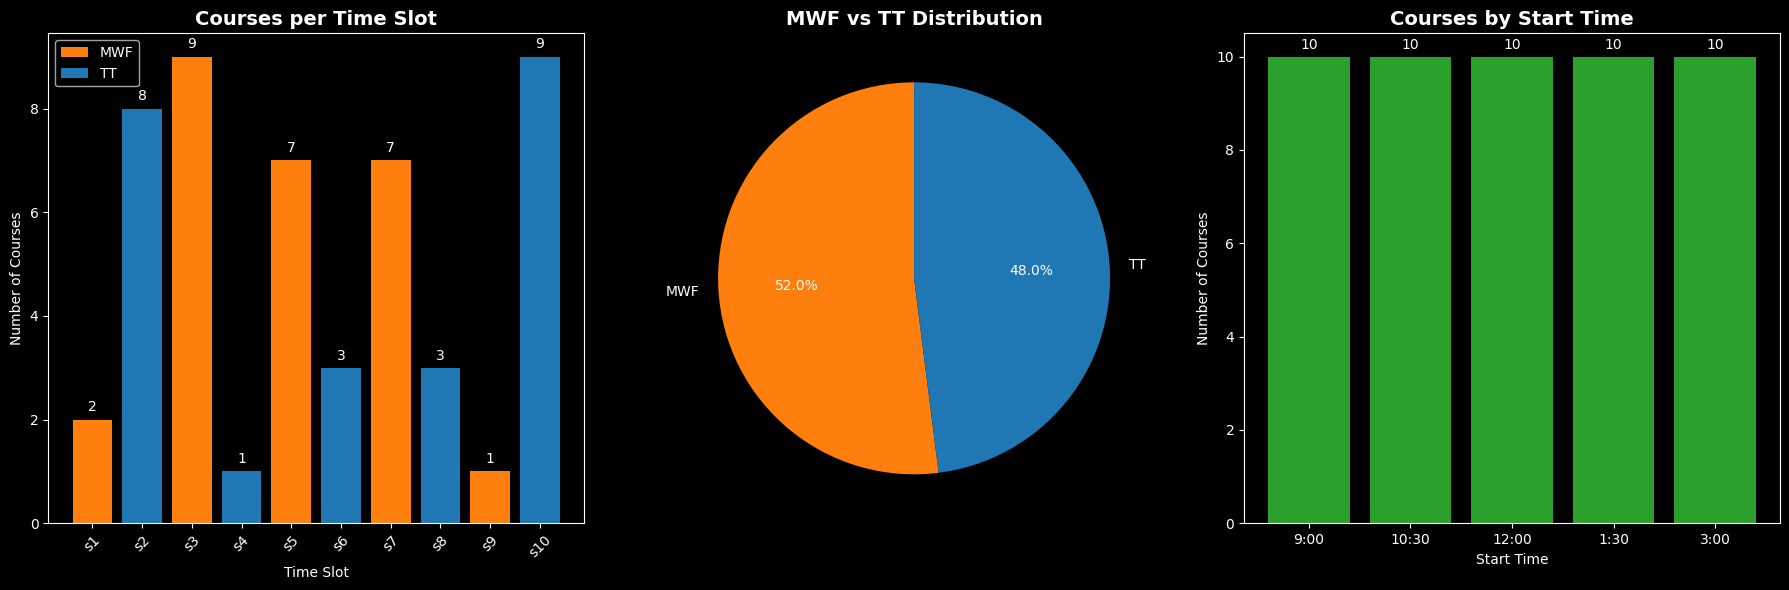

In [92]:
# Visualize results

# Create course distribution chart
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Chart 1: Courses per slot
slot_counts = output.sum(axis=0)
slot_labels = [slot_times[i][1] for i in range(num_slots)]
colors = ['#ff7f0e' if i in mwf_slots else '#1f77b4' for i in range(num_slots)]

bars1 = ax1.bar(slot_labels, slot_counts, color=colors)
ax1.set_title('Courses per Time Slot', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Slot')
ax1.set_ylabel('Number of Courses')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height + 0.1, f'{int(height)}', ha='center', va='bottom')

# Add legend
legend_elements = [Patch(facecolor='#ff7f0e', label='MWF'), Patch(facecolor='#1f77b4', label='TT')]
ax1.legend(handles=legend_elements)

# Chart 2: MWF vs TT distribution
day_pattern_data = [mwf_count, tt_count]
day_pattern_labels = ['MWF', 'TT']
ax2.pie(day_pattern_data, labels=day_pattern_labels, autopct='%1.1f%%', colors=['#ff7f0e', '#1f77b4'], startangle=90)
ax2.set_title('MWF vs TT Distribution', fontsize=14, fontweight='bold')

# Chart 3: Start time distribution
start_time_counts = [t900_count, t1030_count, t1200_count, t130_count, t300_count]
start_time_labels = ['9:00', '10:30', '12:00', '1:30', '3:00']
bars3 = ax3.bar(start_time_labels, start_time_counts, color='#2ca02c')
ax3.set_title('Courses by Start Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Start Time')
ax3.set_ylabel('Number of Courses')

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2.0, height + 0.1, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


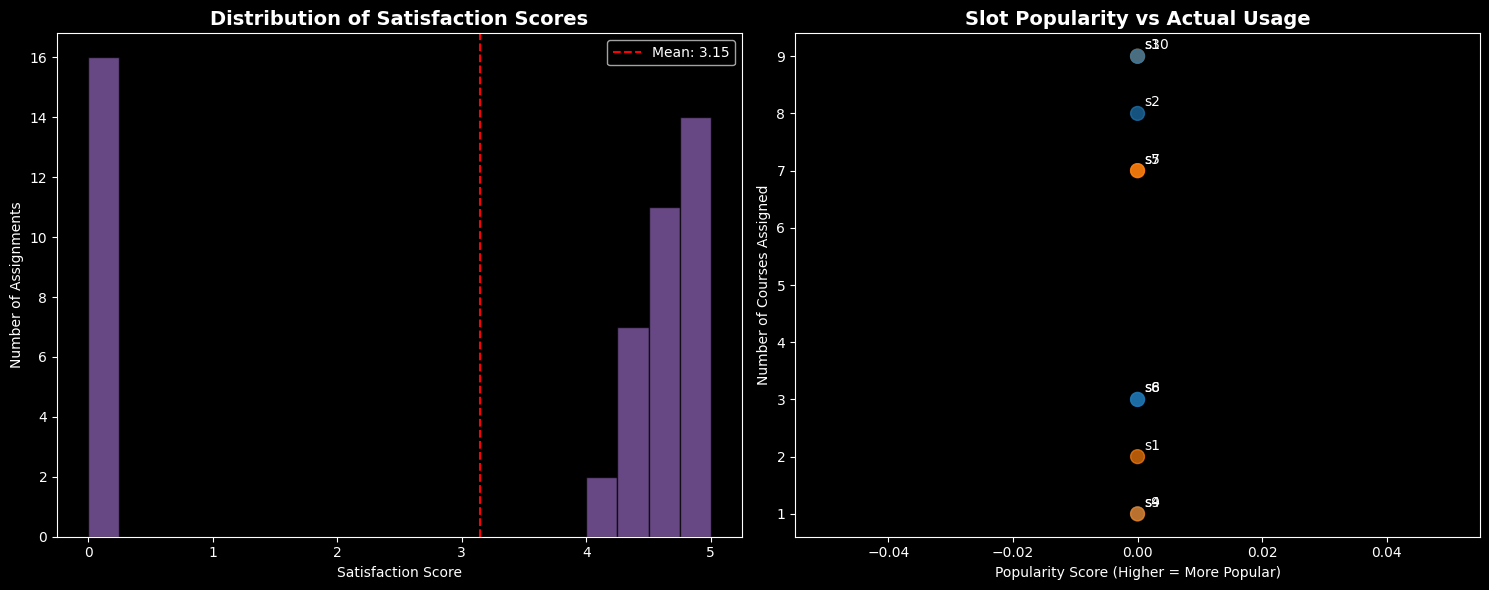

In [93]:
# Satisfaction analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Satisfaction scores per assignment
satisfaction_scores = [entry[3] for entry in results]
ax1.hist(satisfaction_scores, bins=20, color='#9467bd', alpha=0.7, edgecolor='black')
ax1.set_title('Distribution of Satisfaction Scores', fontsize=14, fontweight='bold')
ax1.set_xlabel('Satisfaction Score')
ax1.set_ylabel('Number of Assignments')
ax1.axvline(
    np.mean(satisfaction_scores),
    color='red',
    linestyle='--',
    label=f'Mean: {np.mean(satisfaction_scores):.2f}',
)
ax1.legend()

# Chart 2: Slot popularity vs actual usage
slot_usage = {slot_times[i][1]: slot_counts[i] for i in range(num_slots)}
popularity_values = list(slot_popularity.values())
usage_values = list(slot_usage.values())
slot_names = list(slot_usage.keys())

scatter = ax2.scatter(
    popularity_values,
    usage_values,
    c=['#ff7f0e' if s in mwf_set else '#1f77b4' for s in slot_names],
    s=100,
    alpha=0.7,
)
ax2.set_title('Slot Popularity vs Actual Usage', fontsize=14, fontweight='bold')
ax2.set_xlabel('Popularity Score (Higher = More Popular)')
ax2.set_ylabel('Number of Courses Assigned')

# Add slot labels to points
for i, slot in enumerate(slot_names):
    ax2.annotate(slot, (popularity_values[i], usage_values[i]), xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()


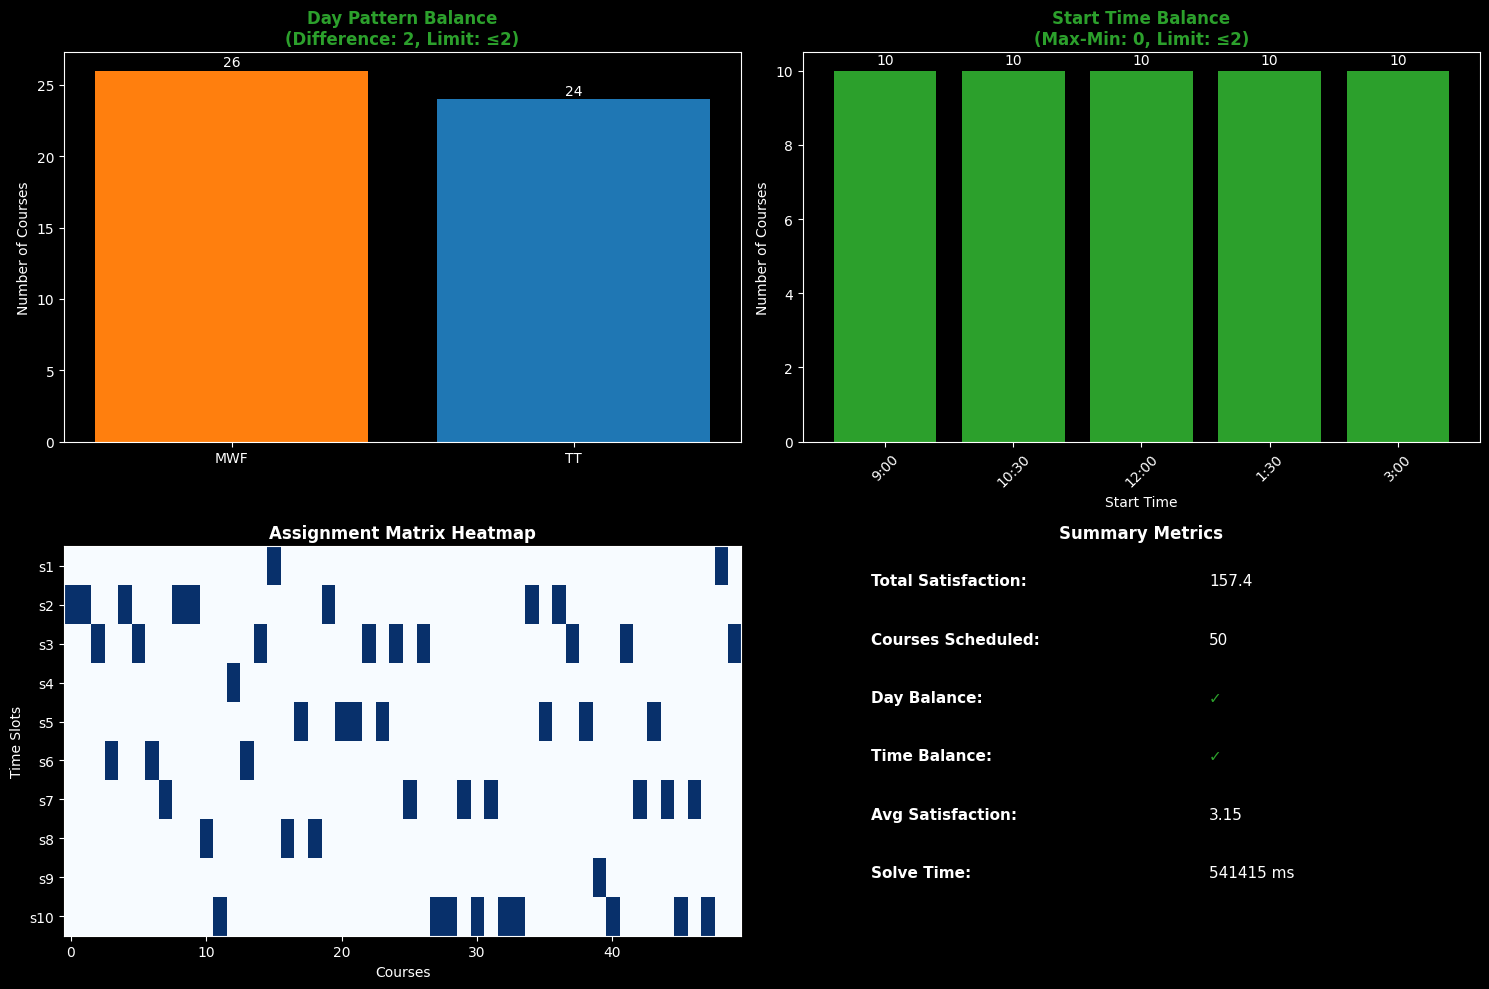

In [94]:
# Constraint compliance dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Chart 1: MWF vs TT balance
balance_data = [mwf_count, tt_count]
balance_diff = abs(mwf_count - tt_count)
compliance_color = '#2ca02c' if balance_diff <= 2 else '#d62728'  # noqa: PLR2004

bars1 = ax1.bar(['MWF', 'TT'], balance_data, color=['#ff7f0e', '#1f77b4'])
ax1.set_title(
    f'Day Pattern Balance\n(Difference: {balance_diff}, Limit: ≤2)',
    fontsize=12,
    fontweight='bold',
    color=compliance_color,
)
ax1.set_ylabel('Number of Courses')

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height + 0.1, f'{int(height)}', ha='center', va='bottom')

# Chart 2: Start time balance
start_counts = [t900_count, t1030_count, t1200_count, t130_count, t300_count]
start_labels = ['9:00', '10:30', '12:00', '1:30', '3:00']
start_diff = max(start_counts) - min(start_counts)
start_compliance_color = '#2ca02c' if start_diff <= 2 else '#d62728'  # noqa: PLR2004

bars2 = ax2.bar(start_labels, start_counts, color='#2ca02c')
ax2.set_title(
    f'Start Time Balance\n(Max-Min: {start_diff}, Limit: ≤2)',
    fontsize=12,
    fontweight='bold',
    color=start_compliance_color,
)
ax2.set_xlabel('Start Time')
ax2.set_ylabel('Number of Courses')
ax2.tick_params(axis='x', rotation=45)

# Add values on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height + 0.1, f'{int(height)}', ha='center', va='bottom')

# Chart 3: Course assignments heatmap
heatmap_data = output.T  # transpose to have slots as rows
slot_labels_full = [slot_times[i][2] for i in range(num_slots)]
im = ax3.imshow(heatmap_data, cmap='Blues', aspect='auto')
ax3.set_title('Assignment Matrix Heatmap', fontsize=12, fontweight='bold')
ax3.set_xlabel('Courses')
ax3.set_ylabel('Time Slots')
ax3.set_yticks(range(num_slots))
ax3.set_yticklabels([f'{slot_times[i][1]}' for i in range(num_slots)])

# Chart 4: Summary metrics
metrics = {
    'Total Satisfaction': f'{solver.Objective().Value():.1f}',
    'Courses Scheduled': f'{num_courses}',
    'Day Balance': '✓' if balance_diff <= 2 else f'✗ ({balance_diff})',  # noqa: PLR2004
    'Time Balance': '✓' if start_diff <= 2 else f'✗ ({start_diff})',  # noqa: PLR2004
    'Avg Satisfaction': f'{np.mean(satisfaction_scores):.2f}',
    'Solve Time': f'{solver.WallTime()} ms',
}

ax4.axis('off')
ax4.set_title('Summary Metrics', fontsize=12, fontweight='bold')
y_pos = 0.9
for metric, value in metrics.items():
    color = '#2ca02c' if '✓' in value else '#d62728' if '✗' in value else 'white'
    ax4.text(0.1, y_pos, f'{metric}:', fontsize=11, fontweight='bold', transform=ax4.transAxes)
    ax4.text(0.6, y_pos, value, fontsize=11, color=color, transform=ax4.transAxes)
    y_pos -= 0.15

plt.tight_layout()
plt.show()